In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.svm import SVC
!pip install openpyxl

In [2]:
def rbf(x,y,l=1):
    """Gaussian kernel

    Parameters
    -------------------------------
    x : float
    a real number

    y : float
    a real number

    l: float, non zero
    a scale parameter
    -------------------------------
    """
    dim = x.shape[0]
    vect = np.empty(dim)
    if dim == y.shape[0]  :
        d = np.exp(-((np.linalg.norm(x-y))**2)/(2*(l**2)))
        return d
    else :
        for i in range(dim):
            vect[i] = np.exp(-((np.linalg.norm(x[i] - y))**2)/(2*(l**2)))
        return vect

In [3]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]

In [4]:
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
test_tree = DecisionTreeClassifier().fit(X=max_elemental.drop(['class'],axis=1),
                                          y=max_elemental['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_
df_imp_feat = pd.DataFrame(np.hstack((imp_feat.reshape(imp_feat.shape[0],1),names_feat.reshape(imp_feat.shape[0],1))))
df_imp_feat.columns = ['features', 'name']
df_imp_feat = df_imp_feat.sort_values('features', ascending=False)

df_diff_z = df_imp_feat[df_imp_feat['features'] != 0]


failed = list_failed['MAX']
failed = list(failed)

for i in max_elemental.index:
    if i in failed:
        max_elemental.loc[i,'class'] = -1


number_of_atoms = np.empty(n_samples)
compteur = 0
for element in max_elemental.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = max_elemental.columns.copy()
normalized = max_elemental.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(n_samples,1)
max_elem_norm = pd.DataFrame(normalized)
max_elem_norm['class'] = max_elemental['class'].copy()
max_elem_norm.columns = columns_name
max_elem_norm['compound_name'] = max_elemental.index
max_elem_norm = max_elem_norm.set_index('compound_name',drop=True)

max_elem_norm['class'] = max_elemental['class'].copy()
list_of_imp_names = list(df_diff_z['name'])
list_of_imp_names.append('label')
list_of_imp_names.append('class')
max_elem_norm = max_elem_norm.filter(items=list_of_imp_names, axis=1)



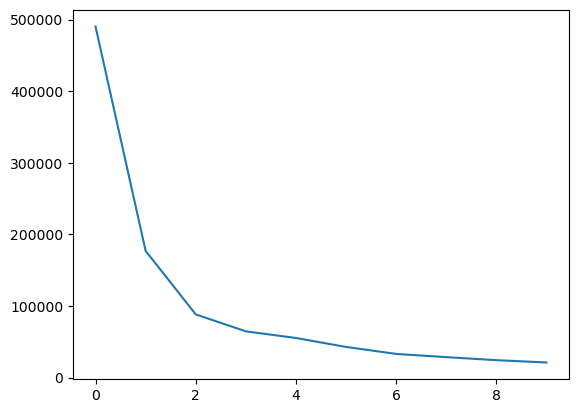

In [5]:
list_inertia = np.zeros(10)
for i in range(1,11):
    det_n_clusters = KMeans(n_clusters=i).fit(X=max_elem_norm.drop(['class'],axis=1).to_numpy())
    list_inertia[i-1] = det_n_clusters.inertia_

plt.plot(list_inertia)

In [6]:
#probably 5 clusters will do the trick, maybe

In [7]:
max_elem_norm['label'] = np.empty(n_samples)
for i in max_elem_norm.index:
    if max_elem_norm.loc[i,'class'] == 1:
        max_elem_norm.loc[i,'label'] = 1
    else:
        max_elem_norm.loc[i,'label'] = -1

positive_samples = max_elem_norm[max_elem_norm['label'] == 1]
unlabelled_samples = max_elem_norm[max_elem_norm['label'] == -1]

n_cluster = 5
clusterized_data = KMeans(n_clusters=n_cluster, init='random').fit(max_elem_norm.to_numpy()[:,:-2])
max_elem_norm['cluster'] = clusterized_data.labels_

list_of_ratio = []
for i in range(n_cluster):
    list_of_ratio.append(max_elem_norm[max_elem_norm['cluster'] == i]['label'].sum()/max_elem_norm[max_elem_norm['cluster'] == i]['class'].shape[0])
list_of_ratio = np.array(list_of_ratio)
positive_cluster = np.argmax(list_of_ratio)
negative_cluster = np.argmin(list_of_ratio)
print('the cluster containing positive values is : ', positive_cluster, '\n', 
      'the one containing negative exampels is : ', negative_cluster)

reliable_positives = max_elem_norm[max_elem_norm['cluster'] == positive_cluster]
reliable_positives = reliable_positives[reliable_positives['label'] == 1]
reliable_negatives = max_elem_norm[max_elem_norm['cluster'] == negative_cluster]
reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
reliable_negatives = reliable_negatives.sample(n=reliable_positives.shape[0]) #to adjust the class balance ratio

the cluster containing positive values is :  4 
 the one containing negative exampels is :  2


In [8]:
#first svm part
gamma = 1
positives_array = reliable_positives.drop(['class','cluster'], axis=1)
negatives_array = reliable_negatives.drop(['class', 'cluster'], axis=1)
data_svm = np.vstack((positives_array,negatives_array))
n_reliable = data_svm.shape[0]
outcome = data_svm[:,-1]
data_svm = data_svm[:,:-1]
omega = np.zeros((n_reliable,n_reliable))
for k in range(n_reliable):
    for i in range(k,n_reliable):
        omega[k,i] = outcome[k]*outcome[i]*rbf(x=data_svm[k,:],y=data_svm[i,:],l=10)
omega_t = np.transpose(omega)
omega = omega_t + omega
for i in range(n_reliable):
    omega[i,i] = 1


#now, computation of the rest of the matrix
first_row = np.hstack((0,-np.transpose(outcome)))
first_row = first_row.reshape(1,first_row.shape[0])
bot_of_mat_right = omega + (1/gamma)*np.eye(n_reliable)
bot_of_mat = np.hstack((outcome.reshape(n_reliable,1), bot_of_mat_right))
whole_mat = np.vstack((first_row, bot_of_mat))
right_hand = np.ones(n_reliable+1)
right_hand[0] = 0

#we get the coefficients
coeffs = np.linalg.solve(a=whole_mat,b=right_hand)
b = coeffs[0]
alpha = coeffs[1:coeffs.shape[0]]

#now we compute the wt \phi(x) and then we order them 
test_data = max_elem_norm.drop(['class','label','cluster'], axis=1).to_numpy()
results = np.empty(n_samples)
for i in tqdm(range(n_samples)):
    results[i] = np.sum(alpha*outcome*rbf(x=data_svm,y=test_data[i,:],l=10))
sorted_results = np.sort(results)
good_ratio = int(n_samples/2)
b = sorted_results[good_ratio]

last_results = np.empty(n_samples)
for i in range(n_samples):
    last_results[i] = np.sign(results[i] - b)

max_elem_norm['it_results'] = last_results
correct_with_b = 0
for i in range(reliable_positives.shape[0]):
    if max_elem_norm.loc[reliable_positives.index[i],'it_results'] == 1:
        correct_with_b += 1
missclass = reliable_positives.shape[0] - correct_with_b

100%|██████████| 2262/2262 [00:00<00:00, 7350.32it/s]


In [9]:
compteur = 0
max_iter = 500
while missclass!=0 and compteur<max_iter:
    compteur += 1
    b = (1+0.05)*b
    last_results = np.empty(n_samples)
    for i in range(n_samples):
        last_results[i] = np.sign(results[i] - b)

    max_elem_norm['it_results'] = last_results
    correct_with_b = 0
    for i in range(reliable_positives.shape[0]):
        if max_elem_norm.loc[reliable_positives.index[i],'it_results'] == 1:
            correct_with_b += 1
    missclass = reliable_positives.shape[0] - correct_with_b

In [10]:
max_elem_norm_it = max_elem_norm

In [11]:
compteur=0
max_iter=10
good_ratio = int(n_samples/2)
while True and compteur<max_iter:
    compteur+=1
    for i in range(n_samples):
        if max_elem_norm_it.loc[max_elem_norm.index[i],'it_results'] == 0:
            max_elem_norm_it.loc[max_elem_norm.index[i],'it_results'] = -1
    positives_new = max_elem_norm_it[max_elem_norm_it['it_results'] == 1]
    positives_new = positives_new[positives_new['label'] == 1]
    negatives_new = max_elem_norm_it[max_elem_norm_it['it_results'] == -1]
    negatives_new = negatives_new[negatives_new['label'] == -1]
    negatives_new = negatives_new.sample(n=positives_new.shape[0])
    #first svm part
    gamma = 1
    positives_array_new = positives_new.drop(['class','cluster','label'], axis=1)
    negatives_array_new = negatives_new.drop(['class', 'cluster','label'], axis=1)
    data_svm_it = np.vstack((positives_array_new,negatives_array_new))
    n_reliable = data_svm_it.shape[0]
    outcome_it = data_svm_it[:,-1].copy()
    data_svm_it = data_svm_it[:,:-1].copy()
    #compute omega
    omega_it = np.zeros((n_reliable,n_reliable))
    for k in range(n_reliable):
        for i in range(k,n_reliable):
            omega_it[k,i] = outcome_it[k]*outcome_it[i]*rbf(x=data_svm_it[k,:],y=data_svm_it[i,:],l=10)
    omega_it_t = np.transpose(omega_it)
    omega_it = omega_it+omega_it_t
    for i in range(n_reliable):
        omega_it[i,i] = 1
    
    first_row_it = np.hstack((0,-np.transpose(outcome_it)))
    first_row_it = first_row_it.reshape(1,first_row_it.shape[0])
    bot_of_mat_right_it = omega_it + (1/gamma)*np.eye(n_reliable)
    bot_of_mat_it = np.hstack((outcome_it.reshape(n_reliable,1), bot_of_mat_right_it))
    whole_mat_it = np.vstack((first_row_it, bot_of_mat_it))
    right_hand_it = np.ones(n_reliable+1)
    right_hand_it[0] = 0
    coeffs_it = np.linalg.solve(a=whole_mat_it,b=right_hand_it)
    b_it = coeffs_it[0]
    alpha_it = coeffs_it[1:coeffs_it.shape[0]]
    test_data_it = max_elem_norm_it.drop(['class','label','cluster','it_results'], axis=1).to_numpy()
    results_new = np.empty(n_samples)
    #the results in the previous algo is now 'new_results'

    
    for i in range(n_samples):
        results_new[i] = np.sum(alpha_it*outcome_it*rbf(x=data_svm_it,y=test_data_it[i,:],l=10))
    sorted_results_it = np.sort(results_new)
    b_it = sorted_results_it[good_ratio]
    last_results_it = np.empty(n_samples)
    for i in range(n_samples):
        last_results_it[i] = np.sign(results_new[i] - b)
    correct_with_b_it = 0 
    for i in range(max_elem_norm_it[max_elem_norm['label'] == 1].shape[0]):
        if last_results_it[i] == 1:
            correct_with_b_it += 1
    missclass_it = positives_new.shape[0] - correct_with_b_it
    compteur_bis = 0
    max_iter_bis = 200
    ### MODIFICATION HERE TO GET A SCORE
    score = np.empty(n_samples)
    while missclass_it!=0 and compteur_bis<max_iter_bis:
        compteur_bis += 1
        b_it = (1-0.05)*b_it
        last_results_bis = np.empty(n_samples)
        for i in range(n_samples):
            last_results_bis[i] = np.sign(results_new[i] - b_it)
            score[i] = results_new[i] - b_it
        correct_with_b_bis = 0

        for i in range(max_elem_norm_it[max_elem_norm['label'] == 1].shape[0]):
            if last_results_bis[i] == 1:
                correct_with_b_bis += 1
        missclass_it = positives_new.shape[0] - correct_with_b_bis
    stop_counter = 0
    for i in range(n_samples):
        if max_elem_norm_it.loc[max_elem_norm.index[i],'it_results'] != last_results_bis[i]:
            stop_counter += 1
    if stop_counter == 0:
        break
        compteur = max_iter
    else:
        max_elem_norm_it['it_results'] = last_results_bis
max_elem_norm_it['score'] = score
alpha_it_final = alpha_it.copy()
outcome_it_final = outcome_it.copy()

In [12]:
positives = 0
true_positives = 0
for i in range(n_samples):
    if last_results_bis[i] == 1:
        positives += 1
        if max_elem_norm_it.loc[max_elem_norm.index[i],'class'] == 1:
            true_positives += 1


recall_train = true_positives/max_elem_norm[max_elem_norm['class'] == 1].shape[0]
weird_thing_train = (recall_train**2)/(positives/n_samples)

In [13]:
print(recall_train, '\n',
      weird_thing_train)

1.0 
 1.9982332155477034


In [14]:
ordered_df_pred = max_elem_norm[max_elem_norm['it_results'] == 1].sort_values(by='score',ascending=False)

In [15]:
ordered_df_pred = ordered_df_pred.head(50)

In [16]:
ordered_df_pred = pd.DataFrame(ordered_df_pred['score'])

In [17]:
ordered_df_pred.columns = ['score_pseudo_it_svm']

In [18]:
ordered_df_pred = ordered_df_pred.reset_index()
ordered_df_pred['rank_pseudo_it_svm'] = ordered_df_pred.index
ordered_df_pred = ordered_df_pred.set_index(keys='compound_name')

In [19]:
ordered_df_pred.to_csv(path_or_buf='ordered_predictions_pseudo_it_svm.csv')